# Аналитический обзор пользовательского взаимоотношения с карточками статей Яндекс.Дзен

### Техническое задание

**Бизнес-задача:** анализ взаимодействия пользователей с карточками Яндекс.Дзен.

**Состав данных для дашборда:**
- История событий по темам карточек (два графика - абсолютные числа и процентное соотношение);
- Разбивка событий по темам источников;
- Таблица соответствия тем источников темам карточек.

**Параметры группировки данных:**
- Дата и время;
- Тема карточки;
- Тема источника;
- Возрастная группа.

**Характер данных:**
- История событий по темам карточек — абсолютные величины с разбивкой по минутам;
- Разбивка событий по темам источников — относительные величины (% событий);
- Соответствия тем источников темам карточек - абсолютные величины.

**В процессе исследования необходимо разрешить следующие вопросы:**

- Cколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
- Как много карточек генерируют источники с разными темами?
- Как соотносятся темы карточек и темы источников?


In [1]:
!pip install psycopg2

In [2]:
import pandas as pd
pd.set_option('display.float_format', '{:.0f}'.format)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(14, 8)})

from sqlalchemy import create_engine

db_config = {'user': 'praktikum_student',
            'pwd': 'Sdf4$2;d-d30pp',
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432,
            'db': 'data-analyst-zen-project-db'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

query = '''SELECT * FROM dash_visits'''

dash_visits = pd.io.sql.read_sql(query, con = engine)

In [3]:
dash_visits.sample(5)

,record_id,item_topic,source_topic,age_segment,dt,visits
6800,1047397,Интересные факты,Авто,18-25,2019-09-24 19:00:00,26
20255,1060852,Полезные советы,Семейные отношения,41-45,2019-09-24 18:54:00,5
23744,1064341,Рассказы,Семейные отношения,41-45,2019-09-24 18:57:00,9
16985,1057582,Отношения,Путешествия,26-30,2019-09-24 18:28:00,1
28619,1069216,Туризм,Семейные отношения,31-35,2019-09-24 18:55:00,29


In [4]:
dash_visits.to_csv('dash_visits.csv')

#### Cколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?

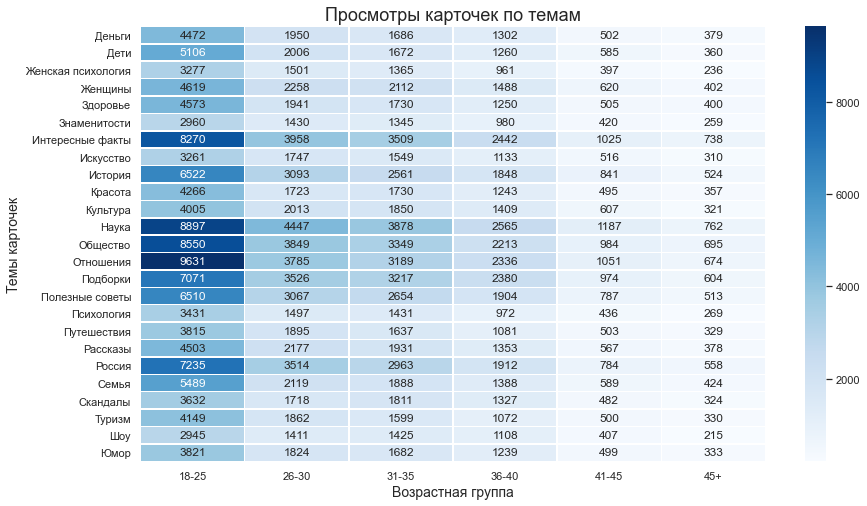

In [5]:
(
    sns.heatmap(dash_visits.pivot_table(index='item_topic', 
                                        columns='age_segment', 
                                        values='visits', 
                                        aggfunc='sum'),
               annot=True,
               linewidths=.5,
               cmap='Blues',
               fmt='g')
)

plt.title('Просмотры карточек по темам', fontsize=18)
plt.ylabel('Темы карточек', fontsize=14)
plt.xlabel('Возрастная группа', fontsize=14)
plt.show()


**Вывод**

1. Есть три способа взаимодействия пользователей с системой:
- Карточка отображена для пользователя (show);
- Пользователь кликнул на карточку (click);
- Пользователь просмотрел статью карточки (view).

2. Подавляющее взаимодействие с сервисом происходить среди пользователей возрастной категории 18-25 лет по темам "Отношения" - 9631, "Наука" - 8897, "Общество" и "Интересные факты" - 8550 и 8270 соответсвенно.

3. Пассивный отклик на сервис наблюдается в возрастной категория 45+. Топовыми темами стали "Наука" - 762, "Интересные факты" - 738, "Общество" и "Отношения" по 695 и 674 соответсвенно.

,item_topic,item_topic_total_visits,item_topic_visits_share
0,Наука,21736,0
1,Отношения,20666,0
2,Интересные факты,19942,0
3,Общество,19640,0
4,Подборки,17772,0
5,Россия,16966,0
6,Полезные советы,15435,0
7,История,15389,0
8,Семья,11897,0
9,Женщины,11499,0


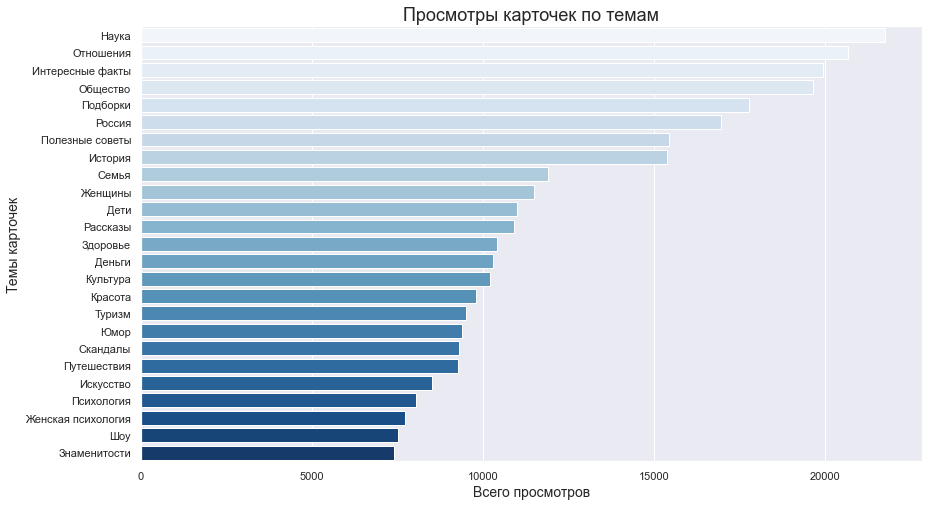

In [6]:
total_visits = (
    dash_visits.groupby('item_topic')['visits']
    .sum()
    .to_frame()
    .rename(columns={'visits': 'item_topic_total_visits'})
    .sort_values('item_topic_total_visits', ascending=False)
    .assign(item_topic_visits_share = lambda x: x['item_topic_total_visits'] / x['item_topic_total_visits'].sum())
    .reset_index()
               )

total_visits.to_excel('total_visits.xlsx')

display(total_visits)

(
    sns.barplot(data=total_visits,
                x='item_topic_total_visits',
                y='item_topic',
               palette='Blues')
                
)

plt.title('Просмотры карточек по темам', fontsize=18)
plt.ylabel('Темы карточек', fontsize=14)
plt.xlabel('Всего просмотров', fontsize=14)
plt.show()

**Вывод (продолжение)**

4. Среди всех подписчиков сервиса топовыми темами стали: "Наука" - 21736, "Отношения" - 20666, "Интересные факты" - 19942, "Общество" и "Подборки" 19640 и 17772.

5. Темы-аутсайдера: "Искусство" - 8516, "Психология" - 8036, "Женская психология" - 7737, "Шоу" и "Знаменитости" 7511 и 7394 соответственно.

#### Как много карточек генерируют источники с разными темами?

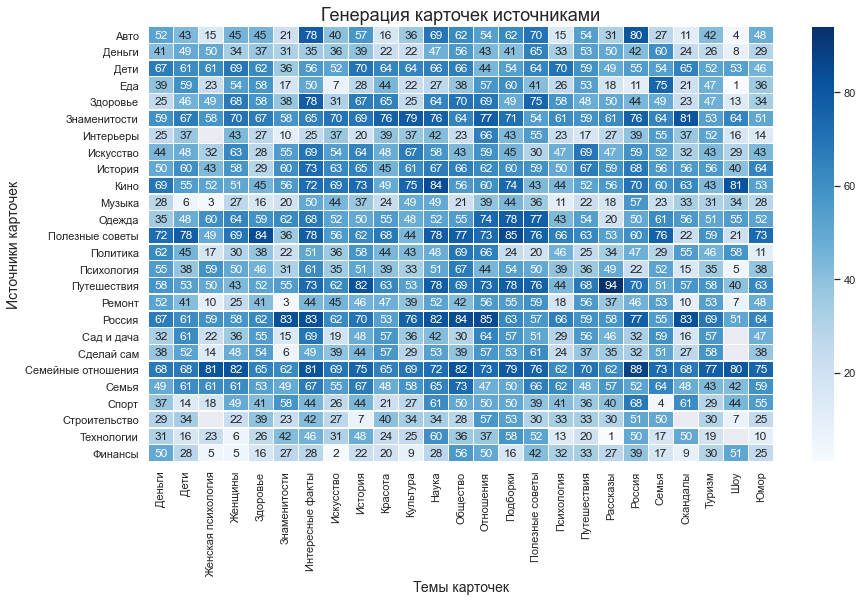

In [7]:
(
    sns.heatmap(dash_visits.pivot_table(index='source_topic', 
                                        columns='item_topic', 
                                        values='record_id', 
                                        aggfunc='count'), 
                annot=True, 
                linewidths=.5, 
                cmap='Blues', 
                fmt='g')
    
)

plt.title('Генерация карточек источниками', fontsize=18)
plt.ylabel('Источники карточек', fontsize=14)
plt.xlabel('Темы карточек', fontsize=14)
plt.show()

**Вывод**

1. Каждую карточку определяют её тема и источник (у источника также имееться тема).

2. Популярностью пользуються источники "Путешествия" по теме "Рассказы" - 94 карточки, "Семейные отношения" - "Россия" - 88 карточек, "Россия" - "Общество" - 85 карточек, "Россия" - "Знаменитости", "Интересные факты" по 83 карточки и "Россия" - "Наука" - 82 карточки.

3. Менее популярны "Еда" - "Искусство", "Ремонт" - "Шоу", "Строительство" - "История" и "Шоу", "Еда" - "Искусство" по 7... По одной карте сгенерировала пара "Технолгии"- "Рассказы", "Еда" - "Шоу".

,source_topic,total_records,records_share
0,Семейные отношения,1822,0
1,Россия,1687,0
2,Знаменитости,1650,0
3,Полезные советы,1578,0
4,Путешествия,1563,0
5,Кино,1505,0
6,Дети,1459,0
7,История,1437,0
8,Семья,1405,0
9,Одежда,1379,0


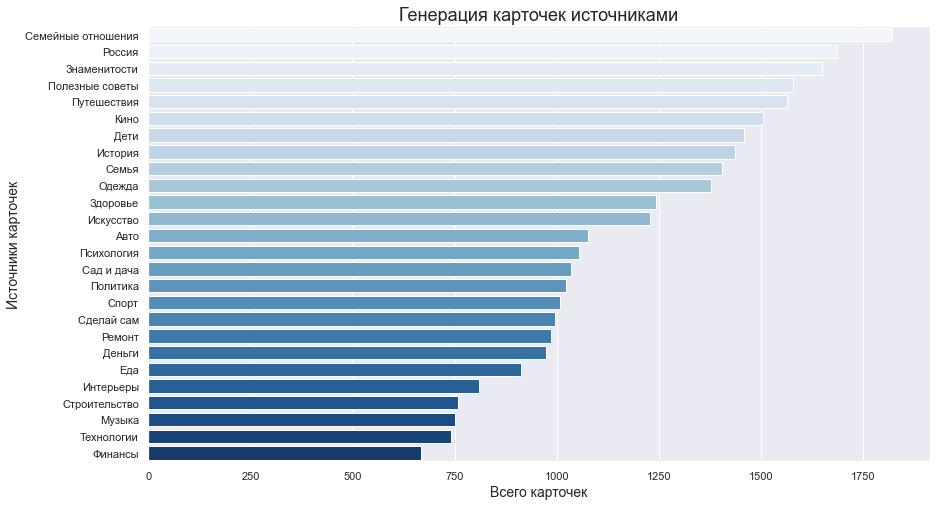

In [8]:
total_record = (
    dash_visits.groupby('source_topic')['record_id']
    .count()
    .to_frame()
    .rename(columns={'record_id': 'total_records'})
    .sort_values('total_records', ascending=False)
    .assign(records_share = lambda x: x['total_records'] / x['total_records'].sum())
    .reset_index()
)

total_record.to_excel('total_record.xlsx')

display(total_record)

(
    sns.barplot(data=total_record,
                x='total_records',
                y='source_topic',
               palette='Blues')
                
)

plt.title('Генерация карточек источниками', fontsize=18)
plt.ylabel('Источники карточек', fontsize=14)
plt.xlabel('Всего карточек', fontsize=14)
plt.show()

**Вывод (продолжение)**

4. В общем массиве топые источники представлены следующими темами: "Семейные отношения" - 1822, "Россия" - 1687, "Знаменитости" - 1650, "Полезны советы" - 1578, "Путешествия" - 1563.

5. Меньше всего заметок создано темами "Еда" - 912, "Интерьер" - 809, "Строительство" и "Музыка" 758 и 750 соответсвенно, "Технологии" - 741, "Финансы" - 667.

#### Как соотносятся темы карточек и темы источников?

item_topic,Деньги,Дети,Женская психология,Женщины,Здоровье,Знаменитости,Интересные факты,Искусство,История,Красота,...,Психология,Путешествия,Рассказы,Россия,Семья,Скандалы,Туризм,Шоу,Юмор,Total
source_topic,,,,,,,,,,,,,,,,,,,,,
Авто,338,192,26,156,232,29,1254,145,522,29,...,19,343,78,1885,50,14,161,4,224,9567
Деньги,203,228,256,122,95,55,145,98,114,48,...,86,363,454,229,458,35,74,8,79,5157
Дети,859,621,613,875,798,145,327,639,1047,703,...,1233,509,286,493,361,844,406,297,404,15243
Еда,193,675,67,348,558,36,391,7,60,253,...,62,357,28,23,1236,48,382,1,194,6892
Здоровье,65,346,349,1022,404,139,2090,70,771,736,...,583,187,248,282,275,43,311,20,124,12831
Знаменитости,591,1444,546,967,962,445,720,1083,921,1313,...,582,509,615,1579,689,1992,269,829,334,23945
Интерьеры,62,97,0,175,57,12,54,164,30,185,...,46,26,47,134,321,93,279,30,17,3614
Искусство,172,238,96,485,64,356,697,512,695,232,...,306,555,291,355,288,91,173,66,205,8001
История,271,455,181,560,68,644,1273,596,636,177,...,286,1018,568,1104,266,410,618,215,715,14628


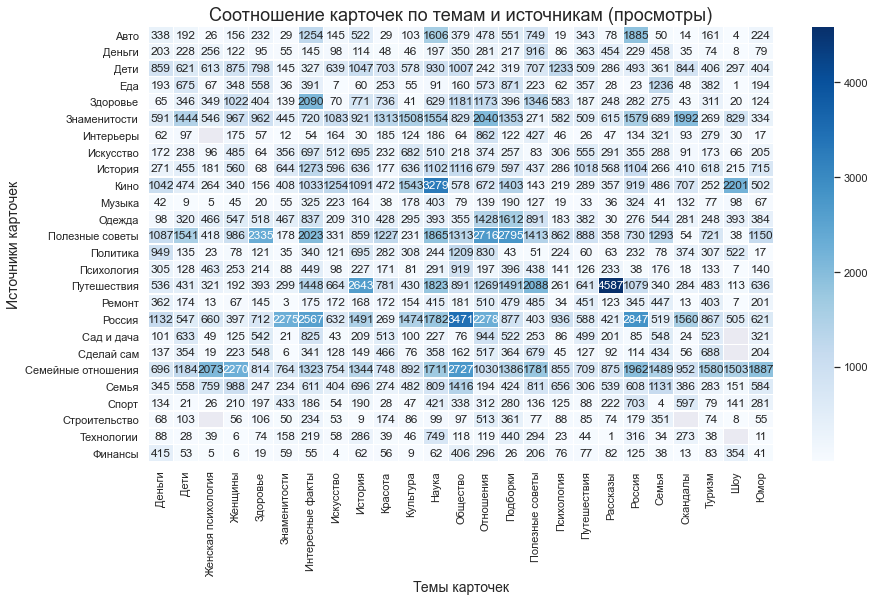

In [9]:
dash_visits_cross = (
    dash_visits
    .pivot_table(index='source_topic', 
                            columns='item_topic', 
                            values='visits', 
                            aggfunc='sum',
                            margins=True,
                            margins_name='Total')
    .fillna(0)
    
)

display(dash_visits_cross)

dash_visits_cross.to_excel('dash_visits_cross.xlsx')

(
    sns.heatmap(dash_visits.pivot_table(index='source_topic', 
                                        columns='item_topic', 
                                        values='visits', 
                                        aggfunc='sum'), 
                annot=True, 
                linewidths=.5, 
                cmap='Blues', 
                fmt='g')
    
)

plt.title('Соотношение карточек по темам и источникам (просмотры)', fontsize=18)
plt.ylabel('Источники карточек', fontsize=14)
plt.xlabel('Темы карточек', fontsize=14)
plt.show()

**Вывод**

1. Лидерами просмотров за весь период предоставленных на анализ данных по всем возрастным категориям являеться соотноешеие источника "Путешествие" и темы "Рассказы" - 4587 просмотров. Первенство разделяют пары "Россия" - "Общество" - 3471 просмотр и   "Кино"- "Наука" - 3279 просмотров.

2. Наименее популярны пары "Технологии" - "Рассказы" и "Еда" - "Шоу" по одному просмотру.

### Дашборд

**Источники данных для дашборда:** сырые данные о событиях взаимодействия пользователей с карточками.

**База данных, в которой будут храниться агрегированные данные:** дополнительные агрегированные таблицы в БД.

**Частота обновления данных:** один раз в сутки, в полночь по UTC.

Аналитический обзор взаимодействия пользователей с карточками Яндекс.Дзен.

**Состав данных для дашборда:**
- История событий по темам карточек (два графика - абсолютные числа и процентное соотношение);
- Разбивка событий по темам источников;
- Таблица соответствия тем источников темам карточек.

**Характер данных:**
- История событий по темам карточек — абсолютные величины с разбивкой по минутам;
- Разбивка событий по темам источников — относительные величины (% событий);
- Соответствия тем источников темам карточек - абсолютные величины.

<https://public.tableau.com/app/profile/valentin.morozov/viz/__16346314113140/sheet4>

### Презентация

<https://yadi.sk/d/3I34fSgyEZ-_QQ>